## Example of how to load and plot DIC data from ECCO-Darwin output

- Montly-averaged 3D outputs from ECCO-Darwin model can be found (downloaded from) here:

  https://ecco.jpl.nasa.gov/drive/files/ECCO2/LLC270/ECCO-Darwin_extension/budget/average_DIC_3d

- The grid $(x,y,z)$ can be found (downloaded from) here:

  https://ecco.jpl.nasa.gov/drive/files/ECCO2/LLC270/ECCO-Darwin_extension/grid

&emsp; &emsp; You will need these files: 

&emsp; &emsp; - $x$-coordinates: XC.meta and XC.data

&emsp; &emsp; - $y$-coordinates: YC.meta and YC.data

&emsp; &emsp; - $z$-coordinates: RC.meta and RC.data

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

from matplotlib.gridspec import GridSpec
import matplotlib as mpl
%matplotlib inline

### Preliminary functions for loading/plotting:

In [3]:
## Load the file in: 
#    grid is organized such that there are 13 tiles with 270 grid points in (x,y) and 50 grid points in z
def decode_llc(fname, nTr):
    ########################################
    # Set llc270 grid basic dimensions     :
    ########################################
    nX=270; nY=nX*13; nZ=50
    ########################################
    # Read binary file :
    ########################################
    with open(fname, 'rb') as fid:
        tmp = np.fromfile(fid, '>f4')
    fld = tmp.reshape((nTr,nZ,nY,nX))
    return(fld)

In [5]:
## Plot the 13 tiles in the native layout format
def plot_tiles(data, tsz):
    #### Initiate ####
    iid = [4,3,2,4,3,2,1,1,1,1,0,0,0]
    jid = [0,0,0,1,1,1,1,2,3,4,2,3,4]
    tid = 0
    #### plot ####
    fig = plt.figure(figsize=(10,10))
    gs = GridSpec(5, 5, wspace=.05, hspace=.05)
    for i in range(len(iid)):
        ax = fig.add_subplot(gs[iid[i],jid[i]])
        if i>=7:    # tile 7 之后的 tile 需要旋转方向
            ax.imshow(data[tid:tid+tsz].T,origin='lower')
        else:
            ax.imshow(data[tid:tid+tsz],origin='lower')
        tid += tsz
        ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    plt.show()

In [7]:
## Some of the tiles are natively "scrambled" in (x,y) directions, so this function "un-scrambles" them
def transp_tiles(data):
    nx = data.shape[1]
    ny = data.shape[0]
    
    tmp = data[7*nx:,::-1]    # [::-1]，横向翻转，tile 7~12 的 x 方向颠倒
    transpo = np.concatenate((tmp[2::3,:].transpose(),tmp[1::3,:].transpose(),tmp[0::3,:].transpose()))    # .transpose()，交换 x 和 y 轴，tile 7~12 的 x/y 轴顺序被错置
    data_out = np.concatenate((data[:7*nx],np.flipud(transpo[:,:nx]),np.flipud(transpo[:,nx:])))    # flipud()，上下翻转，转置后 y 方向也被反了
    return data_out

### Now let's load the data and look at the DIC field! This is an example for the first time step.

In [9]:
# Read file 
filename = "average_DIC_3d.0000002232.data"
num_variables = 15 # 15 variables in this file (see which ones in the .meta file)
data_raw = decode_llc(filename, num_variables)

In [11]:
# Look at the dimensions of the loaded data
#  15 variables, 50 vertical grid points, 13*270 grid points in y (13 tiles times 270 grid points), 270 grid points in x
data_raw.shape

(15, 50, 3510, 270)

In [13]:
# Only need the first variable, which is the DIC concentration
data_dic = data_raw[0]
# make sure dimensions make sense
data_dic.shape

(50, 3510, 270)

In [15]:
# unscramble the tiles 8 to 13: need to do at each depth (vertical) level

for ind in range(data_dic.shape[0]):
    data_dic[ind] = transp_tiles(data_dic[ind])

In [35]:
# Let's also mask out land and sea floor: 
#       DIC is set to zero there in the original data, but let's make it NaN so that it is easier for later calculations

data_dic[data_dic==0] = np.nan

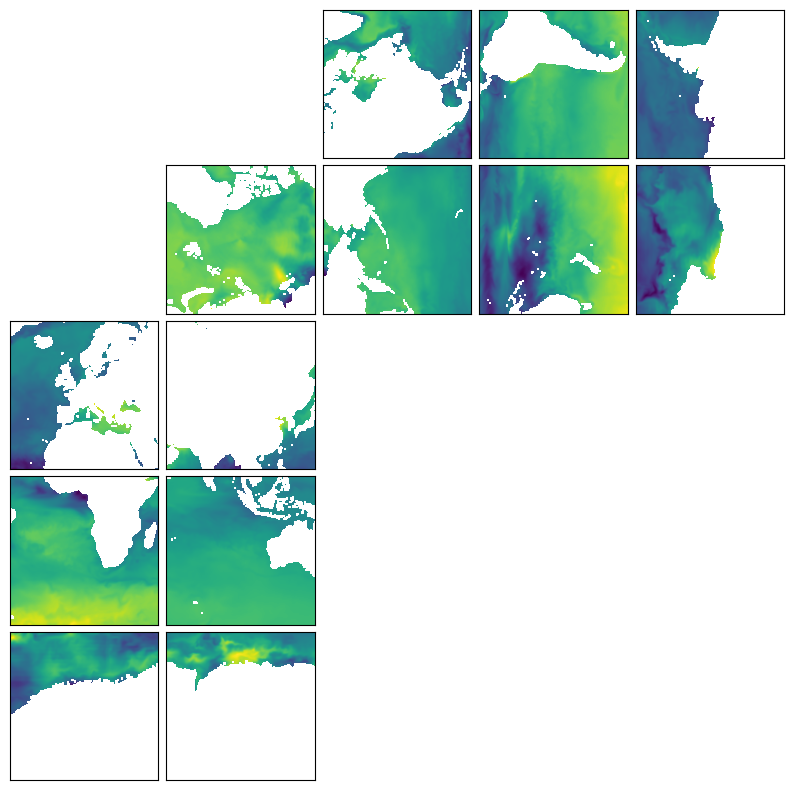

In [37]:
# Plot the surface DIC concentration in the native tile layout (you can see the shapes of the continents)
Nx = 270 # number of grid cells in
plot_tiles(data_dic[0], 270)

### Read in grid files

In [19]:
def decode_llc_grid(fname, ndim):
    ########################################
    # Set llc270 grid basic dimensions     :
    ########################################
    nX=270; nY=nX*13; nZ=50
    ########################################
    # Read binary file :
    ########################################
    with open(fname, 'rb') as fid:
        tmp = np.fromfile(fid, '>f4')
    if ndim==2:
        fld = tmp.reshape((nY,nX))
    else:
        fld = tmp.reshape((nZ,))
    return(fld)

In [21]:
# load (x,y) grid: 2 dimensional
xc = decode_llc_grid('XC.data',2)
xc = transp_tiles(xc)
yc = decode_llc_grid('YC.data',2)
yc = transp_tiles(yc)

# load z-grid: 1 dimensional
z = decode_llc_grid('RC.data',1)

print(xc.shape, yc.shape, z.shape)

(3510, 270) (3510, 270) (50,)


Let's plot vertical profiles of DIC. The plot is set to choose random horizontal locations, so it might hit land and have no data.

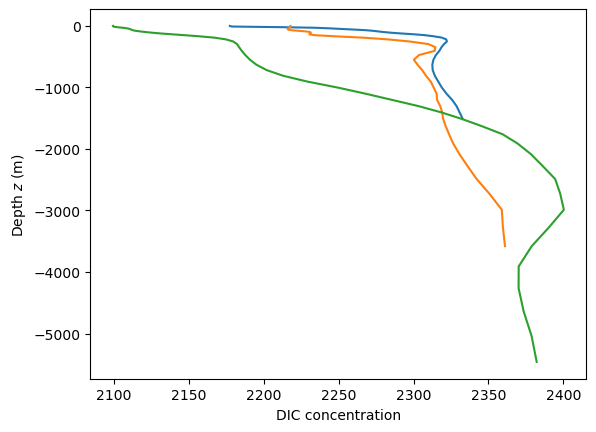

In [45]:
# Plot vertical profile of DIC at a few random locations
fig, ax = plt.subplots()
ax.plot(data_dic[:, np.random.randint(0,3509), np.random.randint(0,269)],z)
ax.plot(data_dic[:, np.random.randint(0,3509), np.random.randint(0,269)],z)
ax.plot(data_dic[:, np.random.randint(0,3509), np.random.randint(0,269)],z)
ax.plot(data_dic[:, np.random.randint(0,3509), np.random.randint(0,269)],z)
ax.set(xlabel = 'DIC concentration', ylabel = 'Depth $z$ (m)')
plt.show()

### Interpolate data onto regular latitude-longitude grid

- This code interpolates the data from the native 13 tiles to the regular latitude-longitude grid with any chosen horizontal grid resolution.

- Will not need this portion of the code for Gaussian Mixture Model clustering, but will need it for plotting clusters for the paper later.

In [49]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library,
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

Here's where the interpolation happens.

In [56]:
# Interpolate onto 1x1 degree horizontal resolution grid 
new_grid_delta_lat = 1
new_grid_delta_lon = 1

# Latitude goes from -90 degrees at the south pole to 90 degrees at the north pole
new_grid_min_lat = -90
new_grid_max_lat = 90

# Longitude goes from -180 degrees to +180 degrees
new_grid_min_lon = -180
new_grid_max_lon = 180


# inputs of the function are:
#    x-coordinates in the native 13 tile format,
#    y-coordinates in the native 13 tile format
#    2D data in the native 13 tile format (in this case, DIC concentrations at the surface)

# outputs of the function are:
#    longitude and latitude of the centers of the interpolated grid cells, 
#    longitude and latitude of the edges of the interpolated grid cells,
#    interpolated 2D data
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
dic_interp =\
        ecco.resample_to_latlon(xc, \
                                yc, \
                                data_dic[0],\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

In [60]:
# Shape of the newly interpolated surface DIC field:
dic_interp.shape

(180, 360)

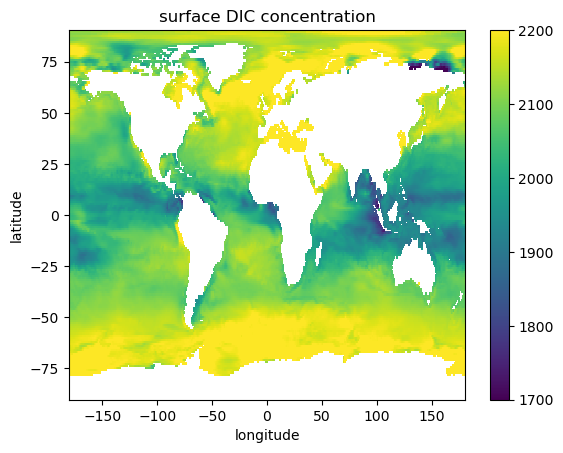

In [74]:
# Plot the interpolated data
lat_interp = np.linspace(-90,90,180)
lon_interp = np.linspace(-180,180,360)

fig, ax = plt.subplots()
im = ax.pcolor(lon_interp, lat_interp, dic_interp, 
               vmin = 1700, vmax = 2200)
plt.colorbar(im, ax=ax)
ax.set(xlabel = 'longitude', ylabel = 'latitude',
       title = 'surface DIC concentration')
plt.show()